# Segment Anything Model: automatic mask generation using `transformers` 🤗 library

This notebook demonstrates how to use the Segment Anything Model (SAM) to automatically generate segementation masks on any image. The model was released by Meta AI in the paper [Segment Anything Model](https://ai.facebook.com/research/publications/segment-anything/). The original source code can be found [here](https://github.com/facebookresearch/segment-anything)

The `mask-generation` pipeline, freshly released for SAM, creates a gris of `1024` which are feed in a batch of `points_per_batch` to the model. The examples are inspired from the [original notebook of the authors](https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb).


In [3]:
from PIL import Image
import requests
import numpy as np
import matplotlib.pyplot as plt
import gc

## Utility functions

Run the cells below to import the needed utility functions for displaying the masks!

In [4]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    del mask
    gc.collect()

def show_masks_on_image(raw_image, masks):
  plt.imshow(np.array(raw_image))
  ax = plt.gca()
  ax.set_autoscale_on(False)
  for mask in masks:
      show_mask(mask, ax=ax, random_color=True)
  plt.axis("off")
  plt.show()
  del mask
  gc.collect()

## Model loading

Use the `from_pretrained` method on the `SamForMaskGeneration` class to load the model from the Hub! For the sake of this demonstration we will use the `vit-huge` checkpoint.

In [5]:
from transformers import pipeline
generator = pipeline("mask-generation", model="facebook/sam-vit-huge", device='cpu')

/home/dhanush/miniconda3/envs/SAM/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load the example image

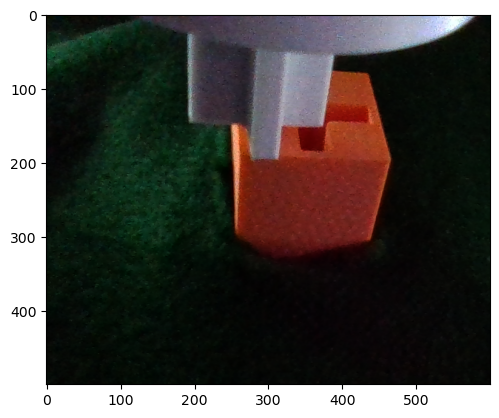

In [6]:
image_path = "/home/dhanush/SIM/data/rgb_10/1723867039536_rgb.png"
raw_image = Image.open(image_path).convert("RGB")
plt.imshow(raw_image)

In [32]:
from transformers import SamModel, SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
model = SamModel.from_pretrained("facebook/sam-vit-base").to("cpu")

# Generate the masks


Let's automatically generate the masks on the image! For that simply pass the raw image into the generator 

In [7]:
outputs = generator(raw_image, points_per_batch=64)

In [31]:
import torch

In [33]:
input_points = [[[325, 90]]]

device = "cpu"

inputs = processor(raw_image, input_points=input_points, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs)
masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())

The line above you take ~7 seconds on Google Colab 1xNVIDIA-T4, now let's see the resulting segmentation masks.

In [ ]:
show_masks_on_image(raw_image, masks)

In [ ]:
masks[0].shape


# Batch of images
You can feed both urls and raw images. Here is an example:

In [ ]:
new_image_url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/depth-estimation-example.jpg"
outputs = generator([raw_image,new_image_url], points_per_batch=64)

In [ ]:
masks = outputs[1]["masks"]
raw_image = Image.open(requests.get(new_image_url, stream=True).raw).convert("RGB")
show_masks_on_image(raw_image, masks)